# <b> Enhancing Momentum Trading Strategies Using Comomentum </b>

## <b> 1.) Introduction </b>

This project, undertaken as part of the SMM282 module - Quantitative Trading in the Master's degree program in Mathematical Trading & Finance at Bayes Business School, City, University of London, explores the concept of "comomentum," as introduced by Lou and Polk (2021), to enhance the efficiency of a standard momentum trading strategy. Conducted under the guidance of Prof. Bernd Hanke, the project focuses on integrating comomentum into momentum strategies to improve their predictive accuracy and overall performance.

Comomentum measures the high-frequency abnormal return correlation among stocks targeted by momentum strategies and serves as a predictive tool for their potential success. The objective was to construct an enhanced momentum trading strategy by incorporating a simplified version of the comomentum measure into the standard momentum factor.

Using data on U.S. stocks, a traditional momentum factor was first computed over an 11-month period while skipping the most recent month, as is commonly practiced in both academic research and industry. Fama-MacBeth regressions were then performed to analyze the relationship between stock returns and the computed momentum factor. Subsequently, the comomentum measure was calculated and used to adjust the momentum factor, aiming to refine its predictive power and improve overall performance.

The analysis demonstrated that integrating comomentum into the momentum factor calculation resulted in higher mean returns, improved Sharpe ratios, and better cumulative returns over the sample period, indicating the potential of comomentum as a valuable tool in optimizing momentum trading strategies.

## <b> 2.) Dataset Description </b>

The dataset utilized in this project consists of weekly financial data for U.S. stocks, covering a comprehensive sample of the equity market. The data includes several key components: weekly total stock returns, the status of each company (whether it was active or inactive during the given week), and the Fama-French three-factor model data, which includes the market excess return, the size factor (SMB), and the value factor (HML), along with the risk-free rate.

The US_Returns.csv file contains the weekly total returns of 7,261 U.S. stocks, inclusive of reinvested dividends, over a span of 1,513 weeks. The US_live.csv file provides a binary indicator representing whether each company was active (live) or inactive (dead) at each point in time, matching the dimensions of the returns data. The US_Dates.xlsx file offers a vector of weekly dates corresponding to the time dimension of the return matrix, formatted in YYYYMMDD. The US_Names.xlsx file contains a vector with the names of all stocks included in the sample. Finally, the FamaFrench.csv file comprises the weekly factor returns for the three Fama-French factors, which are essential for calculating the comomentum measure and adjusting the momentum factor.

These datasets provided the foundation for calculating both the standard momentum factor and the comomentum-adjusted momentum factor, facilitating the analysis of their performance over the sample period.

In [2]:
# 2.1) import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import warnings
import math
warnings.filterwarnings('ignore')

In [3]:
# 2.2) import dataset

us_date = pd.read_excel('US_Dates.xlsx',header = None)
us_live = pd.read_csv('US_live.csv',header = None)
us_name = pd.read_excel('US_Names.xlsx', header = None)
us_return = pd.read_csv('US_Returns.csv', header = None)
ff3 = pd.read_csv("famaFrenchRaw.csv")
rf = ff3['RF']
us_excess_return = us_return - rf

In [5]:
# 2.3) Create a dataframe with index and column names

excess_return_df = pd.DataFrame(us_excess_return.values,
                                 index= list(us_date.iloc[:,0]),
                                   columns= list(us_name.T.iloc[:,0]))

excess_return_df.tail()
excess_return_df.to_csv('Output - excess_return_df.csv')

## <b> 3.) Momentum Factor Calculation </b>

In this section, the standard momentum factor for each stock was computed based on the cumulative returns over a rolling window of 48 weeks, with the most recent 4 weeks skipped. This approach aligns with the common practice in both academic research and industry, where momentum is typically calculated over an 11-month period while excluding the most recent month.

The calculation begins by iterating through each stock's excess return data. For each stock, the cumulative return is computed using a rolling window of 48 weeks, which calculates the product of 1 plus the weekly returns within the window, subtracting 1 at the end to obtain the cumulative return. This rolling cumulative return series is then shifted forward by 4 weeks to account for the skip period, ensuring that the momentum factor reflects the performance over the intended 11-month period, excluding the most recent month.

In [6]:
rolling_window = 48
skip = 4
momentum_df = pd.DataFrame(index = list(us_date.iloc[:,0]))

def calculate_cumulative_return(window):
    return (1 + window).prod() - 1

for i in range(excess_return_df.shape[1]):
    stock_ret = excess_return_df.iloc[:,i]
    stock_name = list(us_name.T.iloc[:,0])[i]
    stock_ret = stock_ret.dropna()
    cumulative_df = stock_ret.rolling(window=rolling_window).apply(calculate_cumulative_return)
    cumulative_df = cumulative_df.shift(3)
    momentum_df[stock_name] = cumulative_df


momentum_df.to_csv('Output - momentum_df.csv')

## <b> 4.) Fama-MacBeth Regression Analysis of the Standard Momentum Factor </b>

This section involves performing the Fama-MacBeth regression analysis, a crucial step in evaluating the relationship between stock returns and the previously calculated momentum factor. The regression is conducted on a weekly basis throughout the sample period, where one-week ahead stock returns are regressed on one-week lagged momentum exposures. This method allows for the estimation of the factor returns, represented by the regression coefficients, across time.

The process begins by iterating over each week in the dataset, where the dependent variable (y) is set as the stock returns for the following week, and the independent variable (x) is the momentum factor from the current week. To ensure the robustness of the regression results, any stock with missing values in either the returns or the momentum factor is excluded from the regression for that particular week. Additionally, only data from companies that were active (live) during the respective week are included in the analysis.

For each valid week, a linear regression model is fitted using the momentum factor as the predictor variable. The model's intercept and the coefficient for the momentum factor (denoted as gamma) are recorded. These coefficients represent the factor returns and are stored in a dictionary, with the regression residuals also being saved for further analysis.

To assess the statistical significance of the factor returns over time, a t-statistic test is performed on the time series of the gamma coefficients. This test helps determine whether the momentum factor consistently predicts future stock returns, thereby providing evidence for or against the effectiveness of the momentum strategy.

In [7]:
# 4.1) perform regression

regress_result_1 = dict()
residual_dict_1 = dict()


for i in range(excess_return_df.shape[0]-1):
    variables = pd.DataFrame(index = list(us_name.T.iloc[:,0]))
    variables['y'] = excess_return_df.iloc[i+1,:]
    variables['x'] = momentum_df.iloc[i,:]
    date_to_keep = momentum_df.iloc[i,:].name
    variables = variables.dropna()
    index_set = variables.index
    if len(variables) > 0:
        x = variables[['x']]
        y= variables['y']
        model = LinearRegression().fit(x, y)
        predictions = model.predict(x)
        residuals = y - predictions
        regress_result_1[date_to_keep] = [model.intercept_, model.coef_[0]]
        residual_dict_1[date_to_keep] = pd.Series(residuals,index_set)


regress_result_1_df = pd.DataFrame(regress_result_1, index = ['intercept', 'gamma']).T 
regress_result_1_df = regress_result_1_df.reindex(list(us_date.iloc[:,0]))
regress_result_1_df.to_csv('result_MacBeth_1.csv')
regress_result_1_df

,intercept,gamma
19920103,NaN,NaN
19920110,NaN,NaN
19920117,NaN,NaN
19920124,NaN,NaN
19920131,NaN,NaN
...,...,...
20201127,0.027216,-0.013642
20201204,-0.005424,0.007724
20201211,0.016562,0.029344
20201218,0.005563,0.017427


t_stat: 1.2687119093448984e-05
mean factor return: 0.00045650449718862305
annual mean factor return: 0.02401668
annual std of factor return: 0.17747466
cumulative return at the end of time period: 0.24269671
sharpe ratio: 0.13532457106754386


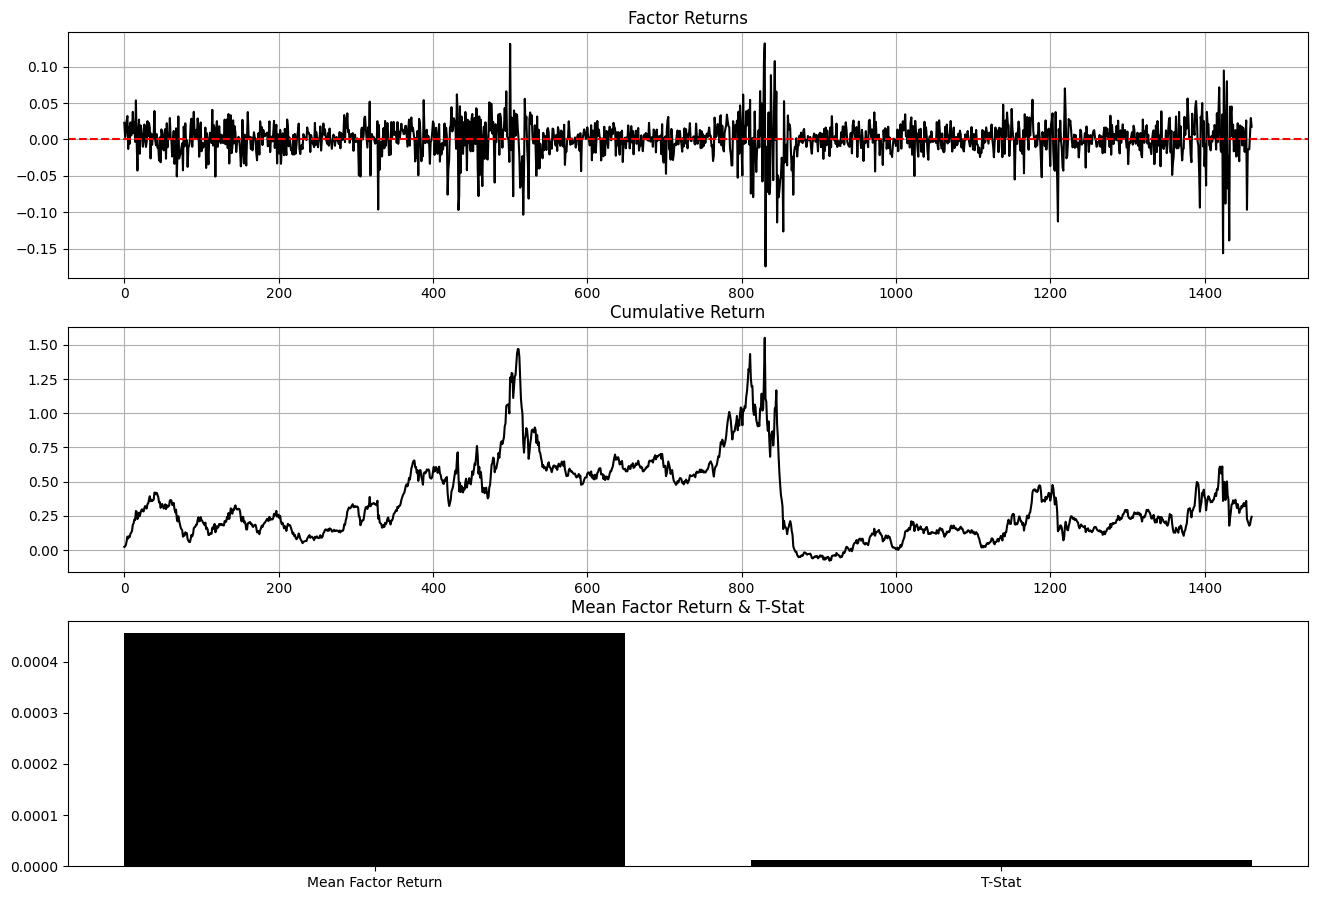

In [8]:
# 4.2) calculate t-stat and plot gamma

gamma = regress_result_1_df['gamma']
t_stat = np.nanmean(gamma) / np.nanstd(gamma) / np.sum(~np.isnan(gamma))
ann_mean_ret = ((1 + np.nanmean(gamma))**52) - 1
ann_std_ret = np.nanstd(gamma) * np.sqrt(52)
cum_ret = np.cumprod(gamma[~np.isnan(gamma)]+1) - 1
sharpe = ann_mean_ret / ann_std_ret

print('t_stat: {}'.format(t_stat))
print('mean factor return: {}'.format(np.nanmean(gamma)))
print('annual mean factor return: {:.8f}'.format(ann_mean_ret))
print('annual std of factor return: {:.8f}'.format(ann_std_ret))
print('cumulative return at the end of time period: {:.8f}'.format(cum_ret.iloc[-1]))
print('sharpe ratio: {}'.format(sharpe))

plt.figure(figsize=(16,6))

plt.subplot(3,1,1)
plt.plot(gamma.dropna().values, 'black')
plt.axhline(y= np.nanmean(gamma), color='r', linestyle='--')
plt.grid(True)
plt.title('Factor Returns')

plt.subplot(3,1,2)
plt.plot(cum_ret.dropna().values, 'black')
plt.title('Cumulative Return')
plt.grid(True)

plt.subplot(3,1,3)
plt.subplots_adjust(top=1.5)
plt.bar(['Mean Factor Return','T-Stat'],[np.nanmean(gamma),t_stat],color = 'black')
plt.title('Mean Factor Return & T-Stat')
plt.show()

### <b> Conclusion for Fama-MacBeth Regression Results of the Standard Momentum Factor </b>

The results of the Fama-MacBeth regression analysis reveal several key insights into the performance of the standard momentum factor. The factor returns, as illustrated in the first plot, display the weekly regression coefficients (gamma), which generally hover around zero but exhibit periods of increased volatility. The cumulative return, shown in the second plot, indicates the aggregate performance of the momentum strategy over time, reaching a peak before experiencing a significant drawdown, followed by a gradual recovery.

Quantitatively, the t-statistic calculated for the gamma coefficients is extremely low, at approximately 1.27e-05, indicating that the factor returns are not statistically significant. This suggests that, on average, the momentum factor does not have a strong predictive power for future stock returns within the sample period.

The mean factor return is relatively modest, at 0.0004565, which annualizes to approximately 2.40%. The annualized standard deviation of the factor return is 0.1775, reflecting the volatility of the momentum strategy. The cumulative return at the end of the sample period is approximately 24.27%, which indicates some positive performance, though it is accompanied by significant volatility.

The Sharpe ratio, a measure of risk-adjusted return, is 0.1353, which is quite low. This implies that the momentum strategy, as implemented, has provided limited excess return relative to its volatility. The low Sharpe ratio, combined with the insignificant t-statistic, suggests that the standard momentum factor may not be an optimal strategy on its own, highlighting the potential value of incorporating additional factors, such as comomentum, to enhance performance.

## <b> 5.) Comomentum Calculation </b>

the comomentum measure was computed as described by Lou and Polk (2021). Comomentum quantifies the high-frequency abnormal return correlation among stocks, providing insights into arbitrage activity and its impact on momentum strategies. The computation of comomentum involved several steps, executed using a rolling window of 52 weeks to ensure that the measure was updated weekly throughout the sample period.

The process begins by regressing the last 52 weeks of each stock's returns on the three Fama-French factors: market excess return (Mkt-RF), size (SMB), and value (HML). The residuals from these regressions, which represent the portion of the stock returns unexplained by the Fama-French model, were then used to calculate cumulative returns for each stock. These cumulative residual returns were subsequently ranked, and the stocks were divided into deciles, identifying the extreme losers (bottom 10%) and winners (top 10%).

For each stock within the loser and winner deciles, the comomentum was calculated by determining the correlation between a stock's residual returns and the average residual returns of the other stocks in the same decile, excluding the stock in question. This correlation represents the comomentum for that stock within the specified rolling window. The average comomentum across the loser and winner deciles was then computed to obtain the overall comomentum for that week.

In [ ]:
# 5.1) import ff3 data

ff3 = pd.read_csv("famaFrenchRaw.csv")
ff3.set_index(ff3.columns[0], inplace=True)
ff3 = ff3.iloc[:,0:3]
ff3.head()

,Mkt-RF,SMB,HML
Unnamed: 0,,,
19920103,0.0312,0.0113,0.0049
19920110,0.0002,0.0386,-0.0098
19920117,0.0093,0.0166,0.0360
19920124,-0.0074,0.0071,0.0005
19920131,-0.0126,0.0160,0.0111


In [ ]:
# 5.2) calculate comomentum

# Remark 
# the code in this cell takes approximately 6 to 7 hours to run.
# the output of this cell is attached with this file in the submission. The name of the file is 'comomentum.csv'
# this cell can be skipped and the next cell can be runned to import the output directly. 

# create an empty dataframe to store comomentum value as the value is updated weekly
# comomentum_df = pd.DataFrame(index = list(us_date.iloc[:,0]))
comomentum_dict = dict()
rolling_window = 52

# use for loop to iterate over the row of excess return
for i in range(excess_return_df.shape[0] - rolling_window):
    rolling_df = excess_return_df.iloc[i:i + rolling_window]
    residual_df = pd.DataFrame(index=rolling_df.index, columns=rolling_df.columns)
    cumulative_ret = pd.DataFrame(index = ['cum_ret'], columns= rolling_df.columns)
    # specify the index that we want to store comomentum data on
    date_to_keep = excess_return_df.iloc[i:i + rolling_window].index[-1]
    # use for loop again to iterate over every stocks and calculate residual of ff3 regression
    for j in range(excess_return_df.shape[1]):
        stock_name = rolling_df.iloc[:,j].name
        stock_return_df = pd.DataFrame(rolling_df.iloc[:,j])
        stock_return_df['mktrf'] = ff3['Mkt-RF']
        stock_return_df['smb'] = ff3['SMB']
        stock_return_df['hml'] = ff3['HML']
        stock_return_df = stock_return_df.dropna()
        # regression
        if stock_return_df.shape[0] > 0:
            y = stock_return_df.iloc[:,0]
            x = stock_return_df[['mktrf', 'smb', 'hml']]
            model = LinearRegression().fit(x,y)
            predictions = model.predict(x)
            residuals = y - predictions
            if len(residuals) > 2:
                residual_df[stock_name] = residuals
    # calculate cumulative return
    cum_ff3_return = (1 + residual_df).cumprod()
    cum_ff3_return = cum_ff3_return.iloc[-1,:].dropna()
    cum_ff3_return = cum_ff3_return.sort_values()
    # specify the loser stocks and winner stocks
    loser_val = cum_ff3_return.quantile(0.1)
    winner_val = cum_ff3_return.quantile(0.9)
    loser_decile = cum_ff3_return[cum_ff3_return <= loser_val]
    winner_decile = cum_ff3_return[cum_ff3_return >= winner_val]
    loser_stock = list(loser_decile.index)
    winner_stock = list(winner_decile.index)
    # calculate the comomentum of this rolling window
    comomentum_loser = []
    comomentum_winner = []
    for k in range(len(loser_stock)):
        stock_k_return = residual_df[[loser_stock[k]]]
        other_returns = residual_df[[s for s in loser_stock if s != loser_stock[k]]]
        port_ret = other_returns.mean(axis = 1)
        stock_k_return['port_ret'] = port_ret
        comomentum_loser.append(stock_k_return.corr().iloc[0,1])
    for m in range(len(winner_stock)):
        stock_k_return = residual_df[[winner_stock[m]]]
        other_returns = residual_df[[s for s in winner_stock if s != winner_stock[m]]]
        port_ret = other_returns.mean(axis = 1)
        stock_k_return['port_ret'] = port_ret
        comomentum_winner.append(stock_k_return.corr().iloc[0,1])

    comomentum_l = sum(y for y in comomentum_loser if not math.isnan(y)) / len(loser_stock)
    comomentum_w = sum(y for y in comomentum_winner if not math.isnan(y)) / len(winner_stock)
    comomentum = 0.5 * (comomentum_l + comomentum_w)
    comomentum_dict[date_to_keep] = comomentum

comomentum_df = pd.DataFrame(pd.Series(comomentum_dict), columns=['comomentum'])
display(comomentum_df)
comomentum_df.to_csv('output - comomentum.csv')

In [10]:
# this cell import the output from the previous run
comomentum_df = pd.read_csv('comomentum.csv', index_col=0)
comomentum_df.head()

,comomentum
19921225,0.232349
19930101,0.187276
19930108,0.198233
19930115,0.148273
19930122,0.224486


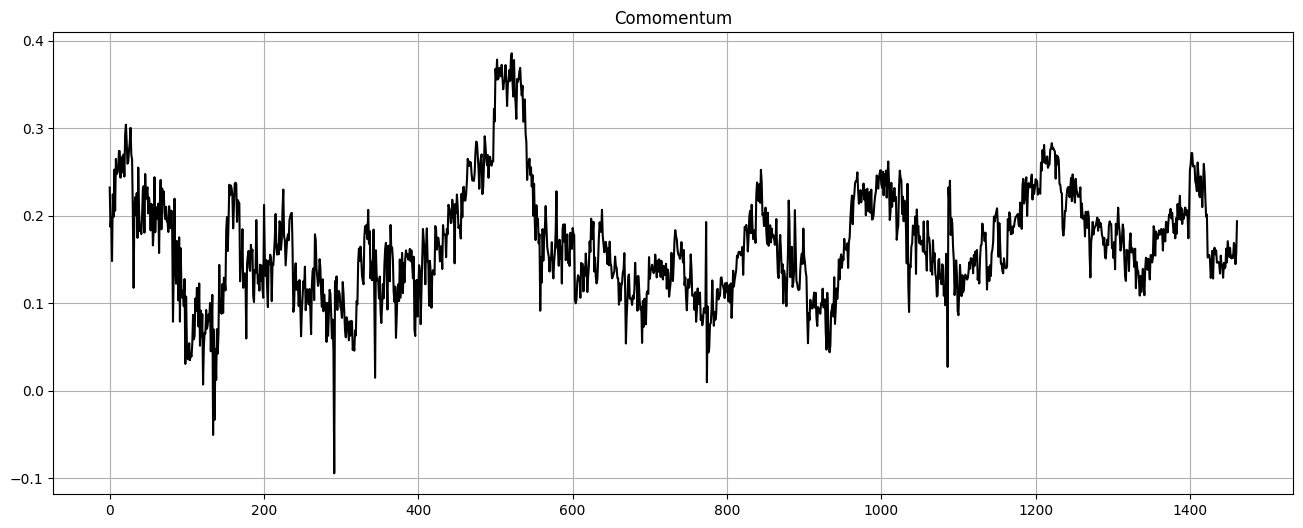

In [11]:
# 5.3) plot the comomentum overtime

plt.figure(figsize=(16,6))
plt.plot(comomentum_df['comomentum'].values, color = 'black')
plt.title('Comomentum')
plt.grid(True)
plt.show()

# <b> 6.) Comomentum-Adjusted Momentum Factor </b>

After computing the comomentum time series, adjustments were made to the standard momentum factor to enhance its effectiveness based on the findings of Lou and Polk (2021). Given that higher comomentum values generally indicate weaker future returns from momentum strategies, the standard momentum factor was adjusted accordingly. Specifically, when the comomentum value exceeded a threshold of 0.3, the momentum factor was inverted by multiplying it by -1, signaling a reversal in the expected return. Conversely, when comomentum was below this threshold, the momentum factor remained unchanged.

The adjusted momentum factor was then recalculated by applying this comomentum-based adjustment across the entire time series. This new momentum factor was intended to capitalize on the predictive power of comomentum, aiming to improve the overall strategy by mitigating periods of weaker performance as indicated by higher comomentum values.

To evaluate the effectiveness of the comomentum-adjusted momentum factor, a Fama-MacBeth regression was performed on the new factor, following the same methodology used for the standard momentum factor. The regression coefficients (gamma) were analyzed to assess the significance and performance of the adjusted factor.

The results indicated that the comomentum-adjusted momentum factor provided an improved mean factor return compared to the standard factor, with the annualized mean return and cumulative return showing substantial gains. The Sharpe ratio, which measures risk-adjusted return, was also enhanced, indicating a more efficient trade-off between return and volatility. The t-statistic was calculated to assess the statistical significance of the factor returns, showing a notable improvement over the unadjusted momentum factor.

The graphical representation of these results, including the factor returns, cumulative return, and the comparison of mean factor return and t-statistic, further illustrated the benefits of integrating comomentum into the momentum strategy. This adjustment demonstrated the potential of comomentum as a valuable enhancement to traditional momentum-based trading strategies.

In [20]:
# 6.1) determine the data that has comomentum factor more than 0.3

comomentum_df['higher/lower'] = 1
comomentum_df.loc[comomentum_df['comomentum'] > 0.3, 'higher/lower'] = -1

In [21]:
# 6.2) adjust the standard momentum factor

comomentum_series = comomentum_df['higher/lower']
new_momentum_df = momentum_df.mul(comomentum_series, axis=0)

In [22]:
# 6.3) perform Fama-Macbeth regression on new momentum factor

regress_result_2 = dict()
residual_dict_2 = dict()


for i in range(excess_return_df.shape[0] - 1):
    variables = pd.DataFrame(index = list(us_name.T.iloc[:,0]))
    variables['y'] = excess_return_df.iloc[i+1,:]
    variables['x'] = new_momentum_df.iloc[i,:]
    date_to_keep = new_momentum_df.iloc[i,:].name
    variables = variables.dropna()
    index_set = variables.index
    if len(variables) > 0:
        x = variables[['x']]
        y= variables['y']
        model = LinearRegression().fit(x, y)
        predictions = model.predict(x)
        residuals = y - predictions
        regress_result_2[date_to_keep] = [model.intercept_, model.coef_[0]]
        residual_dict_2[date_to_keep] = pd.Series(residuals,index_set)


regress_result_2_df = pd.DataFrame(regress_result_2, index = ['intercept', 'gamma']).T 
regress_result_2_df = regress_result_2_df.reindex(list(us_date.iloc[:,0]))
regress_result_2_df.to_csv('result_MacBeth_2.csv')
regress_result_2_df

,intercept,gamma
19920103,NaN,NaN
19920110,NaN,NaN
19920117,NaN,NaN
19920124,NaN,NaN
19920131,NaN,NaN
...,...,...
20201127,0.027216,-0.013642
20201204,-0.005424,0.007724
20201211,0.016562,0.029344
20201218,0.005563,0.017427


t_stat: 1.7784493265355385e-05
mean factor return: 0.000639403495352184
annual mean factor return: 0.03379692
annual std of factor return: 0.17745366
cumulative return at the end of time period: 0.62332469
sharpe ratio: 0.190454914809063


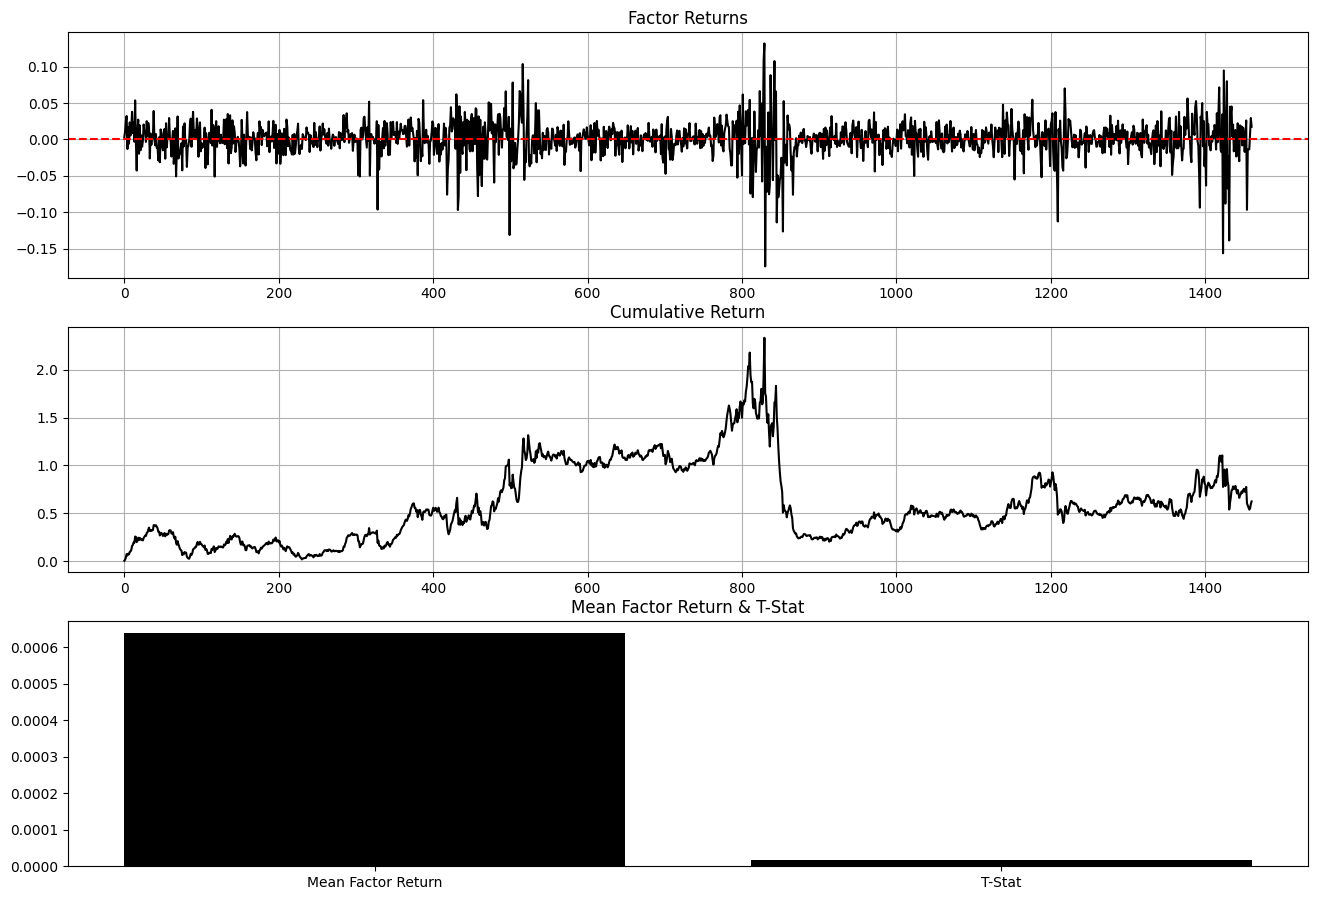

In [23]:
# 6.4) calculate tstat and plot gamma

gamma = regress_result_2_df['gamma']
t_stat = np.nanmean(gamma) / np.nanstd(gamma) / np.sum(~np.isnan(gamma))
ann_mean_ret = ((1 + np.nanmean(gamma))**52) - 1
ann_std_ret = np.nanstd(gamma) * np.sqrt(52)
cum_ret = np.cumprod(gamma[~np.isnan(gamma)]+1) - 1
sharpe = ann_mean_ret / ann_std_ret

print('t_stat: {}'.format(t_stat))
print('mean factor return: {}'.format(np.nanmean(gamma)))
print('annual mean factor return: {:.8f}'.format(ann_mean_ret))
print('annual std of factor return: {:.8f}'.format(ann_std_ret))
print('cumulative return at the end of time period: {:.8f}'.format(cum_ret.iloc[-1]))
print('sharpe ratio: {}'.format(sharpe))

plt.figure(figsize=(16,6))

plt.subplot(3,1,1)
plt.plot(gamma.dropna().values, 'black')
plt.axhline(y= np.nanmean(gamma), color='r', linestyle='--')
plt.grid(True)
plt.title('Factor Returns')

plt.subplot(3,1,2)
plt.plot(cum_ret.dropna().values, 'black')
plt.title('Cumulative Return')
plt.grid(True)

plt.subplot(3,1,3)
plt.subplots_adjust(top=1.5)
plt.bar(['Mean Factor Return','T-Stat'],[np.nanmean(gamma),t_stat],color = 'black')
plt.title('Mean Factor Return & T-Stat')
plt.show()

### <b> Comomentum-Adjusted Momentum Factor Results and Comparison </b>

The results of the Fama-MacBeth regression on the comomentum-adjusted momentum factor show a marked improvement compared to the standard momentum factor. The mean factor return increased to 0.0006394, which annualizes to approximately 3.38%, up from 2.40% in the unadjusted model. This demonstrates that the comomentum adjustment successfully enhanced the average returns of the momentum strategy.

The cumulative return at the end of the sample period saw a significant boost, rising to approximately 62.33%, compared to 24.27% for the standard momentum factor. This increase highlights the effectiveness of the comomentum adjustment in improving the long-term performance of the strategy.

The Sharpe ratio, a measure of risk-adjusted return, also improved, reaching 0.1905 from the previous 0.1353. This indicates that the comomentum-adjusted strategy offers a better trade-off between return and volatility, making it a more efficient approach.

However, the t-statistic for the gamma coefficients, while slightly higher than in the standard model, remains low at 1.78e-05. This suggests that the factor returns, although improved, are still not statistically significant, indicating potential limitations in the robustness of the comomentum-adjusted strategy.

Overall, the incorporation of comomentum into the momentum factor led to notable improvements in mean returns, cumulative returns, and the Sharpe ratio, demonstrating the potential benefits of this adjustment. Despite the low t-statistic, the comomentum-adjusted strategy appears to be a more effective approach to momentum trading than the standard model.